# Image Classfication on "Heart Failure Cinical Records" Dataset
## Author: Nathan Wu
## Course Project, UC Irvine, Math 10, S24
I would like to post my notebook on the course's website. [Y/n] Y

In [149]:
from ucimlrepo import fetch_ucirepo
hf=fetch_ucirepo(
    id=519
)

In [150]:
#url info about this dataset
{x:y for x,y in hf.metadata.items() if "URL" in x.upper()}

{'repository_url': 'https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records',
 'data_url': 'https://archive.ics.uci.edu/static/public/519/data.csv'}

In [151]:
import pandas as pd

In [152]:
type(hf.data)

ucimlrepo.dotdict.dotdict

In [153]:
#ucimlrepo automatically split the data into X and y
#if I want to see the whole df, I have to put them back together
#hf_df=pd.concat([hf.data.features,hf.data.targets],axis=1)
#or
hf_df=pd.read_csv(dict(hf.metadata.items())["data_url"])

In [154]:
#list some data
hf_df[:5]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [155]:
hf_df[-5:]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
294,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.0,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,1,1,280,0
298,50.0,0,196,0,45,0,395000.0,1.6,136,1,1,285,0


In [156]:
#I am seeing:
# dataset represent T/F as 1/0 
# int was wrote as float
# vary big number in some col

In [157]:
#no missing values
hf_df[hf_df.isna().any(axis=1)]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event


In [158]:
#around 32% dead (death_event=1)
sum(hf_df["death_event"])/len(hf_df["death_event"])

0.3210702341137124

## Since the task is a binary classification problem, I will do Logistic Regression first.

### Logistic Regression without anything

In [159]:
import numpy as np 
import matplotlib.pyplot as plt

In [160]:
y_str="death_event"
y=hf_df[y_str]
X=hf_df[[x for x in list(hf_df.columns) if x!=y_str]]

In [161]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [162]:
model_0=LogisticRegression(penalty=None,max_iter=10**10)
model_0.fit(X,y)
#this is the predict rate without any data spliting
model_0.score(X,y)

0.8394648829431438

In [163]:
def show_conf_mat(model,X,y):
    sns.heatmap(
        confusion_matrix(y,model.predict(X)),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=model.classes_,
        yticklabels=model.classes_,
    )

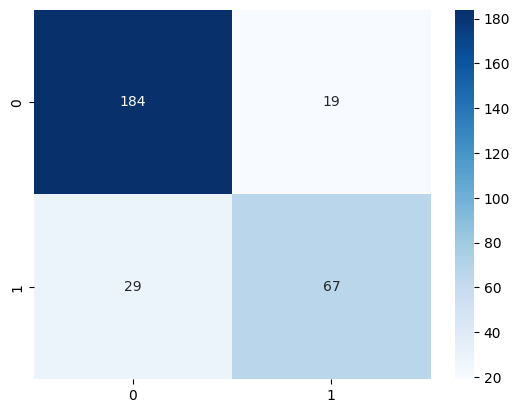

In [164]:
show_conf_mat(model_0,X,y)

### Now I will split the data 8:2

In [165]:
from sklearn.model_selection import train_test_split
SEED=42
#im tried to write X_train and X_test etc.
# my use of _l stand for learn(train), _t stand for test
X_l,X_t,y_l,y_t=train_test_split(X,y,test_size=0.2,random_state=SEED,shuffle=True)

In [166]:
model_1=LogisticRegression(penalty=None,max_iter=10**10)
model_1.fit(X_l,y_l)
#less than 2% acc was lost due to not knowing the full dataset
model_1.score(X_t,y_t),model_0.score(X_t,y_t)-model_1.score(X_t,y_t)

(0.8, -0.01666666666666672)

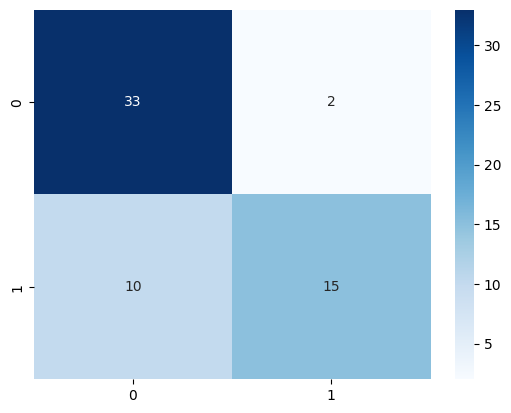

In [167]:
#There are a lot of FN
#which means that the model think a guy is dead but actually the guy survived
show_conf_mat(model_1,X_t,y_t)

## Logistic Regression with Cross Validation

In [168]:
k_vals=(2,11)
ks=[x for x in range(*k_vals)]
ks

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [169]:
from sklearn.model_selection import cross_val_score,KFold
model_2=LogisticRegression(penalty=None,max_iter=10**10)
best_info=[0]
for k in ks:
    kf=KFold(
        n_splits=k,
        shuffle=True,
        random_state=1
    )
    scores=cross_val_score(
        model_2,
        X_l,
        y_l,
        cv=kf,
    )
    best=max(scores)
    if best>best_info[0]:
        best_info=[best,k,list(scores).index(best)]
    print(f"{k=} | {scores=}")
    print(f"{scores.mean()=} | {np.std(scores)=}")
#as fold 10 getting around 92% is likely because of the pure luck
best_info

k=2 | scores=array([0.84166667, 0.78151261])
scores.mean()=0.8115896358543417 | np.std(scores)=0.030077030812324934
k=3 | scores=array([0.8375   , 0.775    , 0.7721519])
scores.mean()=0.7948839662447257 | np.std(scores)=0.030156510297425575
k=4 | scores=array([0.88333333, 0.85      , 0.78333333, 0.77966102])
scores.mean()=0.8240819209039548 | np.std(scores)=0.04420447035105028
k=5 | scores=array([0.875     , 0.83333333, 0.83333333, 0.79166667, 0.80851064])
scores.mean()=0.8283687943262411 | np.std(scores)=0.028160806711743997
k=6 | scores=array([0.875     , 0.825     , 0.825     , 0.775     , 0.825     ,
       0.76923077])
scores.mean()=0.8157051282051282 | np.std(scores)=0.03557114760235953
k=7 | scores=array([0.85714286, 0.88235294, 0.79411765, 0.82352941, 0.82352941,
       0.76470588, 0.82352941])
scores.mean()=0.8241296518607442 | np.std(scores)=0.03568274657311369
k=8 | scores=array([0.83333333, 0.9       , 0.83333333, 0.86666667, 0.73333333,
       0.86666667, 0.73333333, 0.862

[0.9166666666666666, 10, 1]

## Nerual Network With PyTorch

In [170]:
!nvidia-smi

Wed Jun 12 20:07:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              3W /  140W |     356MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [171]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
torch.__version__
SEED=42

In [172]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [173]:
#because there are 13 col, the model have to take 12 inputs
inp_size=len(hf_df.columns)-1

In [174]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [175]:
#normalize the data
scaler=StandardScaler()
X_l=scaler.fit_transform(
    X_l
)
X_t=scaler.transform(X_t)
X_l,X_t

(array([[ 1.16420244,  1.13933179, -0.35037003, ...,  0.74293206,
         -0.67625223, -1.56416577],
        [ 1.16420244, -0.87770745, -0.50593309, ...,  0.74293206,
         -0.67625223,  0.37989712],
        [-0.03281933,  1.13933179, -0.50064183, ...,  0.74293206,
         -0.67625223,  0.4950061 ],
        ...,
        [-0.50609935, -0.87770745,  0.18087256, ...,  0.74293206,
         -0.67625223, -0.56655455],
        [-1.42476533, -0.87770745,  0.0052027 , ...,  0.74293206,
          1.4787382 ,  1.42866789],
        [ 1.58177789, -0.87770745,  0.33961039, ...,  0.74293206,
          1.4787382 , -0.57934444]]),
 array([[ 7.46626996e-01, -8.77707451e-01,  5.20270419e-03,
         -8.26497787e-01,  1.49345268e-01, -7.36162675e-01,
         -2.24743345e+00,  1.32203359e+00, -9.44310219e-02,
          7.42932064e-01,  1.47873820e+00,  1.50540721e+00],
        [-9.23674793e-01,  1.13933179e+00, -2.95340912e-01,
         -8.26497787e-01, -2.80697130e-01, -7.36162675e-01,
          1.

In [176]:
X_l=torch.tensor(X_l,dtype=torch.float32).to(device)
y_l=torch.tensor(y_l,dtype=torch.float32).to(device).unsqueeze(1)
X_t = torch.tensor(X_t, dtype=torch.float32).unsqueeze(1).to(device)
y_t = torch.tensor(y_t.to_numpy(), dtype=torch.float32).unsqueeze(1).to(device)

In [177]:
class HeartFailureNN(nn.Module):
    def __init__(self):
        super(HeartFailureNN, self).__init__()
        self.layer1 = nn.Linear(inp_size, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x


In [178]:
model_3=HeartFailureNN().to(device)

In [179]:
model_3.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 2.2922e-01,  1.7116e-01, -9.3077e-02, -9.1616e-02,  2.2275e-01,
                       -2.3007e-01,  3.1890e-02,  1.7748e-01,  1.8381e-01, -1.3053e-01,
                       -1.4603e-02,  4.1606e-02],
                      [-2.8085e-01, -1.0538e-01,  1.8502e-01, -1.7459e-02,  1.9211e-01,
                       -4.4997e-02, -1.6611e-01, -2.4092e-01,  2.4254e-01, -1.3782e-01,
                       -7.3709e-02,  4.9440e-02],
                      [ 2.0098e-02, -6.7884e-02,  1.2450e-02, -2.4829e-01,  1.5804e-01,
                        2.2427e-01, -7.8982e-02, -2.0919e-01,  2.7983e-01, -3.3181e-02,
                        8.7102e-02,  1.2963e-01],
                      [ 2.5613e-01, -4.7729e-02, -8.6461e-02,  2.5679e-01,  2.8597e-01,
                        1.5136e-01,  2.8460e-01,  1.5277e-01, -5.8291e-02,  2.1879e-01,
                        2.4158e-02,  2.2968e-01],
                      [ 4.1753e-02,  1.7969e-01,  4.8242e-02,  4.

In [180]:
with torch.inference_mode():
    untrained_y_pred=model_3(X_t)
untrained_y_pred

tensor([[[0.6110]],

        [[0.5938]],

        [[0.5459]],

        [[0.6435]],

        [[0.5528]],

        [[0.5590]],

        [[0.5610]],

        [[0.5899]],

        [[0.5955]],

        [[0.5637]],

        [[0.5577]],

        [[0.5635]],

        [[0.5780]],

        [[0.5533]],

        [[0.5728]],

        [[0.5615]],

        [[0.5605]],

        [[0.5734]],

        [[0.5577]],

        [[0.5487]],

        [[0.5576]],

        [[0.5514]],

        [[0.5855]],

        [[0.5635]],

        [[0.5745]],

        [[0.5457]],

        [[0.5580]],

        [[0.5566]],

        [[0.5659]],

        [[0.5654]],

        [[0.5638]],

        [[0.5829]],

        [[0.5533]],

        [[0.5739]],

        [[0.5661]],

        [[0.5917]],

        [[0.5614]],

        [[0.5822]],

        [[0.5721]],

        [[0.5491]],

        [[0.5701]],

        [[0.5642]],

        [[0.5611]],

        [[0.5734]],

        [[0.5728]],

        [[0.5537]],

        [[0.5878]],

        [[0.5

In [181]:
def show_conf_mat(model,X,y):
    sns.heatmap(
        confusion_matrix(y.to("cpu").squeeze().detach().numpy(),torch.round(torch.sigmoid(model(X))).to("cpu").squeeze().detach().numpy()),
        annot=True,
        fmt="d",
        cmap="Blues",

    )

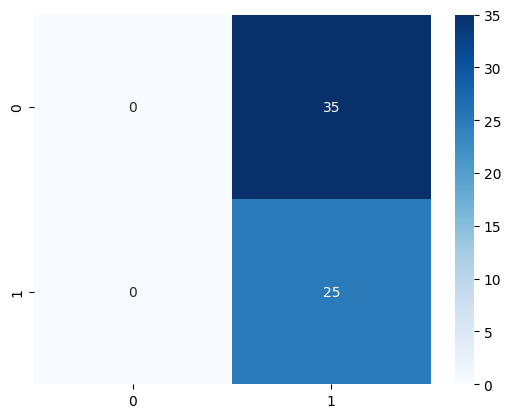

In [182]:
show_conf_mat(model_3,X_t,y_t)

In [183]:
torch.round(untrained_y_pred)

tensor([[[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]

In [184]:
y_t

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [185]:
#had sigmoid ready
loss_fn=nn.BCELoss()
#for binary optim
opt=optim.Adam(model_3.parameters(),lr=0.001)

In [186]:
# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model_3.train()
    opt.zero_grad()
    outputs = model_3(X_l)
    #print(y_l.shape,outputs.shape)
    loss = loss_fn(outputs, y_l)
    loss.backward()
    opt.step()
    

    if (epoch+1) % 200 == 0:
        model_3.eval()
        with torch.inference_mode():
            y_pred=model_3(X_t).squeeze(1)
            t_loss=loss_fn(y_pred,y_t)
            t_acc=(torch.round(torch.sigmoid(y_pred))==y_t).sum()/len(y_t)
        print(f'Epoch [{epoch+1}/{num_epochs}]| Loss: {loss.item()} | Test loss: {t_loss} | Test acc: {t_acc}')

Epoch [200/50000]| Loss: 0.20615744590759277 | Test loss: 0.6159399747848511 | Test acc: 0.4166666865348816
Epoch [400/50000]| Loss: 0.03982704505324364 | Test loss: 1.3452800512313843 | Test acc: 0.4166666865348816
Epoch [600/50000]| Loss: 0.009808346629142761 | Test loss: 1.9476165771484375 | Test acc: 0.4166666865348816
Epoch [800/50000]| Loss: 0.003914010711014271 | Test loss: 2.308140754699707 | Test acc: 0.4166666865348816
Epoch [1000/50000]| Loss: 0.0019957765471190214 | Test loss: 2.579430341720581 | Test acc: 0.4333333671092987
Epoch [1200/50000]| Loss: 0.0012006012257188559 | Test loss: 4.156387805938721 | Test acc: 0.46666669845581055
Epoch [1400/50000]| Loss: 0.0007950253202579916 | Test loss: 4.303135395050049 | Test acc: 0.5
Epoch [1600/50000]| Loss: 0.0005603853496722877 | Test loss: 4.433218955993652 | Test acc: 0.5
Epoch [1800/50000]| Loss: 0.000412351539125666 | Test loss: 4.549786567687988 | Test acc: 0.5333333611488342
Epoch [2000/50000]| Loss: 0.0003135667357128113

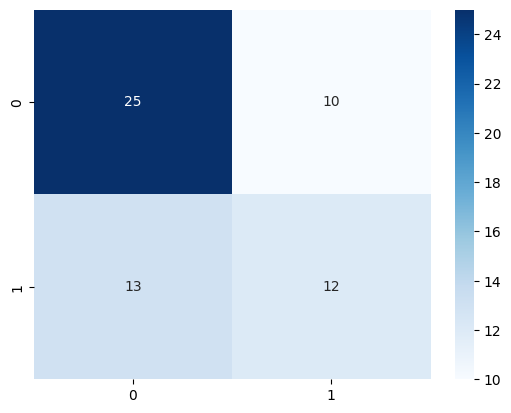

In [187]:
show_conf_mat(model_3,X_t,y_t)

In [188]:
#some testing code to test the dim of matrices of the training loop
model_3.eval()
with torch.no_grad():
    y_pred = model_3(X_t)
y_pred

tensor([[[1.1749e-21]],

        [[3.8824e-23]],

        [[1.7553e-15]],

        [[1.0000e+00]],

        [[1.7950e-16]],

        [[2.8648e-15]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.5038e-12]],

        [[6.2817e-15]],

        [[6.8943e-19]],

        [[1.5233e-15]],

        [[5.1181e-15]],

        [[5.5409e-13]],

        [[1.3733e-23]],

        [[1.5237e-14]],

        [[1.7051e-07]],

        [[2.7596e-20]],

        [[5.4328e-13]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.2664e-03]],

        [[3.8322e-12]],

        [[9.9992e-01]],

        [[3.6692e-22]],

        [[5.3668e-19]],

        [[1.3105e-14]],

        [[1.2365e-14]],

        [[5.1813e-24]],

        [[2.9832e-09]],

        [[1.7931e-22]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.3017e-07]],

        [[1.5817e-04]],

        [[1.6261e-15]],

        [[1.3738e-05]],

        [[2.8454e-11]],

        [[1.8070e-14]],



In [189]:
y_t.shape, y_pred.shape

(torch.Size([60, 1]), torch.Size([60, 1, 1]))

In [190]:
# although the training loss went to around 0, the testing acc is not great...
# I think the model is overfiting the entrie time
# the highest test acc I got was 73%

In [191]:
model_4=nn.Sequential(
    nn.Linear(
        in_features=inp_size,out_features=inp_size
    ),
    nn.ReLU(),
    nn.Linear(
        in_features=inp_size,out_features=1
    )
).to(device)

In [192]:
loss_fn=nn.BCEWithLogitsLoss()#sigmoid build in

opt=torch.optim.SGD(params=model_4.parameters(),lr=0.001)

In [193]:
# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model_4.train()
    opt.zero_grad()
    outputs = model_4(X_l)
    #print(y_l.shape,outputs.shape)
    loss = loss_fn(outputs, y_l)
    loss.backward()
    opt.step()
    

    if (epoch+1) % 200 == 0:
        model_4.eval()
        with torch.inference_mode():
            y_pred=model_4(X_t).squeeze(1)
            t_loss=loss_fn(y_pred,y_t)
            t_acc=(torch.round(torch.sigmoid(y_pred))==y_t).sum()/len(y_t)
        print(f'Epoch [{epoch+1}/{num_epochs}]| Loss: {loss.item()} | Test loss: {t_loss} | Test acc: {t_acc}')

Epoch [200/50000]| Loss: 0.7396892309188843 | Test loss: 0.7253536581993103 | Test acc: 0.40000003576278687
Epoch [400/50000]| Loss: 0.7162843942642212 | Test loss: 0.7126798629760742 | Test acc: 0.4833333492279053
Epoch [600/50000]| Loss: 0.6965829730033875 | Test loss: 0.7027833461761475 | Test acc: 0.5333333611488342
Epoch [800/50000]| Loss: 0.679774284362793 | Test loss: 0.6949777603149414 | Test acc: 0.5333333611488342
Epoch [1000/50000]| Loss: 0.6652429699897766 | Test loss: 0.6887955069541931 | Test acc: 0.6000000238418579
Epoch [1200/50000]| Loss: 0.6525279879570007 | Test loss: 0.6838710904121399 | Test acc: 0.6000000238418579
Epoch [1400/50000]| Loss: 0.6412969827651978 | Test loss: 0.6798798441886902 | Test acc: 0.5833333730697632
Epoch [1600/50000]| Loss: 0.6312581300735474 | Test loss: 0.6766141653060913 | Test acc: 0.6000000238418579
Epoch [1800/50000]| Loss: 0.6222255825996399 | Test loss: 0.6739140152931213 | Test acc: 0.6000000238418579
Epoch [2000/50000]| Loss: 0.6140

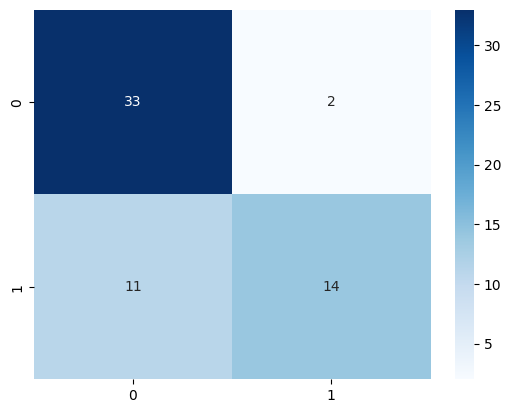

In [194]:
show_conf_mat(model_4,X_t,y_t)

In [195]:
#yeah much better now
#but still overfit

In [196]:
model_5=nn.Sequential(
    nn.Linear(
        in_features=inp_size,out_features=int(inp_size/3)
    ),
    nn.ReLU(),
    nn.Linear(
        in_features=int(inp_size/3),out_features=1
    )
).to(device)

opt=torch.optim.SGD(params=model_5.parameters(),lr=0.001)

In [197]:
# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model_5.train()
    opt.zero_grad()
    outputs = model_5(X_l)
    #print(y_l.shape,outputs.shape)
    loss = loss_fn(outputs, y_l)
    loss.backward()
    opt.step()
    

    if (epoch+1) % 200 == 0:
        model_5.eval()
        with torch.inference_mode():
            y_pred=model_5(X_t).squeeze(1)
            t_loss=loss_fn(y_pred,y_t)
            t_acc=(torch.round(torch.sigmoid(y_pred))==y_t).sum()/len(y_t)
        print(f'Epoch [{epoch+1}/{num_epochs}]| Loss: {loss.item()} | Test loss: {t_loss} | Test acc: {t_acc}')

Epoch [200/50000]| Loss: 0.7560911178588867 | Test loss: 0.7397785186767578 | Test acc: 0.36666667461395264
Epoch [400/50000]| Loss: 0.7375684976577759 | Test loss: 0.7294870018959045 | Test acc: 0.36666667461395264
Epoch [600/50000]| Loss: 0.7212160229682922 | Test loss: 0.7207868695259094 | Test acc: 0.3333333432674408
Epoch [800/50000]| Loss: 0.7065902352333069 | Test loss: 0.7134100794792175 | Test acc: 0.46666669845581055
Epoch [1000/50000]| Loss: 0.6935206055641174 | Test loss: 0.7072007656097412 | Test acc: 0.4833333492279053
Epoch [1200/50000]| Loss: 0.6817338466644287 | Test loss: 0.7020383477210999 | Test acc: 0.4833333492279053
Epoch [1400/50000]| Loss: 0.6710180640220642 | Test loss: 0.6976473927497864 | Test acc: 0.5166667103767395
Epoch [1600/50000]| Loss: 0.6612660884857178 | Test loss: 0.6939241886138916 | Test acc: 0.5166667103767395
Epoch [1800/50000]| Loss: 0.6523156762123108 | Test loss: 0.6907390356063843 | Test acc: 0.5666667222976685
Epoch [2000/50000]| Loss: 0.6

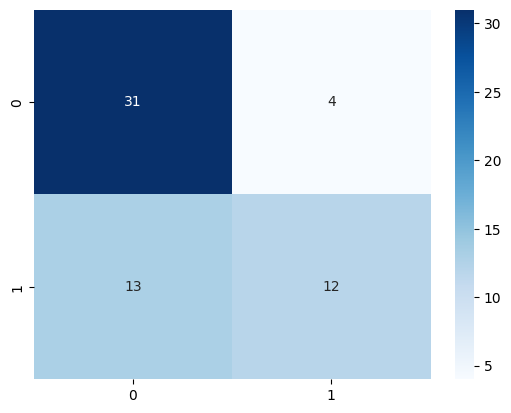

In [198]:
show_conf_mat(model_5,X_t,y_t)

In [199]:
# not too overfitting now
# but simple logistic is still better

In [200]:
# I am gonna try all linear model
model_6=nn.Sequential(
    nn.Linear(
        in_features=inp_size,out_features=int(inp_size/3)
    ),
    nn.Linear(
        in_features=int(inp_size/3),out_features=1
    )
).to(device)

opt=torch.optim.SGD(params=model_6.parameters(),lr=0.001)

In [201]:
# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model_6.train()
    opt.zero_grad()
    outputs = model_6(X_l)
    #print(y_l.shape,outputs.shape)
    loss = loss_fn(outputs, y_l)
    loss.backward()
    opt.step()
    

    if (epoch+1) % 200 == 0:
        model_6.eval()
        with torch.inference_mode():
            y_pred=model_6(X_t).squeeze(1)
            t_loss=loss_fn(y_pred,y_t)
            t_acc=(torch.round(torch.sigmoid(y_pred))==y_t).sum()/len(y_t)
        print(f'Epoch [{epoch+1}/{num_epochs}]| Loss: {loss.item()} | Test loss: {t_loss} | Test acc: {t_acc}')

Epoch [200/50000]| Loss: 0.7499671578407288 | Test loss: 0.7256656289100647 | Test acc: 0.46666669845581055


Epoch [400/50000]| Loss: 0.7119472622871399 | Test loss: 0.6999592185020447 | Test acc: 0.4833333492279053
Epoch [600/50000]| Loss: 0.6783512234687805 | Test loss: 0.6777787804603577 | Test acc: 0.5166667103767395
Epoch [800/50000]| Loss: 0.6482564210891724 | Test loss: 0.6583748459815979 | Test acc: 0.5833333730697632
Epoch [1000/50000]| Loss: 0.6210111379623413 | Test loss: 0.641219973564148 | Test acc: 0.6166666746139526
Epoch [1200/50000]| Loss: 0.5961542129516602 | Test loss: 0.6259424090385437 | Test acc: 0.6500000357627869
Epoch [1400/50000]| Loss: 0.5733592510223389 | Test loss: 0.612276554107666 | Test acc: 0.6666666865348816
Epoch [1600/50000]| Loss: 0.5523925423622131 | Test loss: 0.6000297665596008 | Test acc: 0.7000000476837158
Epoch [1800/50000]| Loss: 0.5330833196640015 | Test loss: 0.5890570878982544 | Test acc: 0.7166666984558105
Epoch [2000/50000]| Loss: 0.5153018832206726 | Test loss: 0.579243540763855 | Test acc: 0.7333333492279053
Epoch [2200/50000]| Loss: 0.498943

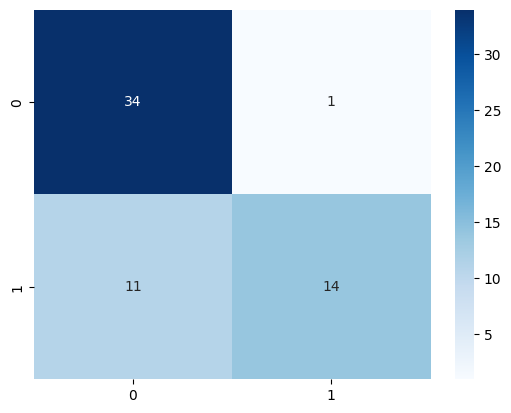

In [202]:
show_conf_mat(model_6,X_t,y_t)

In [203]:
# what if I just do one layer
model_7=nn.Sequential(
    nn.Linear(
        in_features=inp_size,out_features=1
    )
).to(device)

opt=torch.optim.SGD(params=model_7.parameters(),lr=0.001)

In [204]:
# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model_7.train()
    opt.zero_grad()
    outputs = model_7(X_l)
    #print(y_l.shape,outputs.shape)
    loss = loss_fn(outputs, y_l)
    loss.backward()
    opt.step()
    

    if (epoch+1) % 200 == 0:
        model_7.eval()
        with torch.inference_mode():
            y_pred=model_7(X_t).squeeze(1)
            t_loss=loss_fn(y_pred,y_t)
            t_acc=(torch.round(torch.sigmoid(y_pred))==y_t).sum()/len(y_t)
        print(f'Epoch [{epoch+1}/{num_epochs}]| Loss: {loss.item()} | Test loss: {t_loss} | Test acc: {t_acc}')

Epoch [200/50000]| Loss: 0.7786242365837097 | Test loss: 0.7749572992324829 | Test acc: 0.45000001788139343
Epoch [400/50000]| Loss: 0.7412142753601074 | Test loss: 0.746364414691925 | Test acc: 0.4833333492279053
Epoch [600/50000]| Loss: 0.7077879309654236 | Test loss: 0.7210609912872314 | Test acc: 0.5333333611488342
Epoch [800/50000]| Loss: 0.6779264211654663 | Test loss: 0.6986586451530457 | Test acc: 0.5666667222976685
Epoch [1000/50000]| Loss: 0.6512334942817688 | Test loss: 0.6788042187690735 | Test acc: 0.6333333849906921
Epoch [1200/50000]| Loss: 0.6273439526557922 | Test loss: 0.6611822247505188 | Test acc: 0.6666666865348816
Epoch [1400/50000]| Loss: 0.605926513671875 | Test loss: 0.645514726638794 | Test acc: 0.6333333849906921
Epoch [1600/50000]| Loss: 0.5866852402687073 | Test loss: 0.6315580606460571 | Test acc: 0.6500000357627869
Epoch [1800/50000]| Loss: 0.5693582892417908 | Test loss: 0.6191007494926453 | Test acc: 0.6166666746139526
Epoch [2000/50000]| Loss: 0.553715

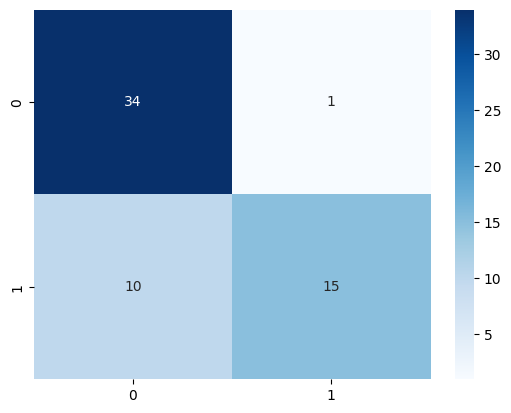

In [205]:
show_conf_mat(model_7,X_t,y_t)

In [206]:
#still not bad

## I want to Do some graphs

### note:
### the features were not scaled yet

Feature 0: age, Score: 0.06319
Feature 1: anaemia, Score: -0.20866
Feature 2: creatinine_phosphokinase, Score: 0.00012
Feature 3: diabetes, Score: 0.53741
Feature 4: ejection_fraction, Score: -0.08143
Feature 5: high_blood_pressure, Score: -0.14597
Feature 6: platelets, Score: -0.00000
Feature 7: serum_creatinine, Score: 0.82379
Feature 8: serum_sodium, Score: 0.00035
Feature 9: sex, Score: -0.68827
Feature 10: smoking, Score: 0.14397
Feature 11: time, Score: -0.02258


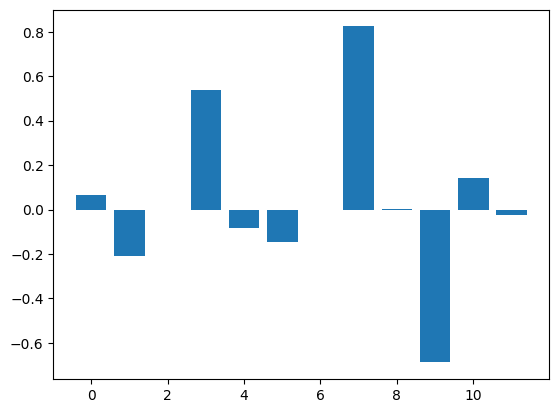

In [207]:
import numpy as np

# Get feature importance
importance = model_1.coef_[0]

# Summarize feature importance
for i, j in enumerate(importance):
    print('Feature %d: %s, Score: %.5f' % (i, X.columns[i], j))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


### scaled version:

In [208]:
X_l1,X_t1,y_l1,y_t1=train_test_split(X,y,test_size=0.2,random_state=SEED,shuffle=True)

In [209]:
X_l1.shape

(239, 12)

In [210]:
#normalize the data
scaler=StandardScaler()
X_l1=scaler.fit_transform(
    X_l1
)
X_t1=scaler.transform(X_t1)
X_l1.shape

(239, 12)

In [211]:
model_8=LogisticRegression()
model_8.fit(X_l1,y_l1)

LogisticRegression()

In [212]:
#same acc but scaled
model_8.score(X_t1,y_t1)

0.8

Feature 0: age, Score: 0.66064
Feature 1: anaemia, Score: -0.05153
Feature 2: creatinine_phosphokinase, Score: 0.11055
Feature 3: diabetes, Score: 0.16412
Feature 4: ejection_fraction, Score: -0.87605
Feature 5: high_blood_pressure, Score: -0.06079
Feature 6: platelets, Score: -0.17025
Feature 7: serum_creatinine, Score: 0.70178
Feature 8: serum_sodium, Score: -0.26049
Feature 9: sex, Score: -0.36242
Feature 10: smoking, Score: 0.07127
Feature 11: time, Score: -1.65188


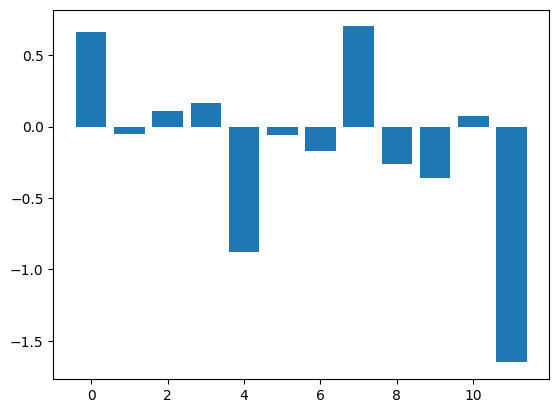

In [213]:
# Get feature importance
importance = model_8.coef_[0]

# Summarize feature importance
for i, j in enumerate(importance):
    print('Feature %d: %s, Score: %.5f' % (i, X.columns[i], j))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


#### As what the logistic model explain, age and serum creatinine level will greatly increase the chance of death on Heart Failure

#### ejection fraction does the opposite

#### time is a really import feature in the model. as in the dataset time is for follow-up period. If the patient did not died, he/she stays around longer

## I would say remove time in the dataset may be more useful on predicting in the real world

### due to my limited knowledge, I was not able to do the same thing with pytorch models
### But as their acc is around the level of logistic models. I assmue they will have vary similar feature importance